# Kamil Pieprzycki 402037

## Lab 3 - Prior and Posterior predictive distributions

### Libraries 

In [2]:
from cmdstanpy import CmdStanModel
import pandas as pd
import arviz as az 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns


/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Modeling prior predictive distribution
1. Create a Stan model, which will consist of only ```generated quantites``` block.
2. In this block define integer variable ```N``` for number of trials equal to 50, integer variable ```y``` for number of successes and real ```p``` for probability of allergic reaction. Remember to use necessary constraints.
3. Assign a prior for  ```p``` (appropriate random number generator) that will represent our knowledge about typical cases. You can do it either analytically or by using simulations. 
4. Sample from binomial distribution, that will use ```N``` and sampled ```p``` to generate number of allergic reactions ```y```.
5. Generate 1000 samples (pair of ```p``` an ```y```) by calling appropriate method in ```cmdstanpy```. Remeber to set ```fixed_param=True```.
6. Compute ratio of allergic reactions for each sample and create a histogram.
7. Verify if mean of the ratio is consistent with prior knowledge, otherwise modify prior parameters. Describe your reasoning in the report. 


In [3]:
stanmodel = CmdStanModel(stan_file='model.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [4]:
sampl = stanmodel.sample(data={"N":50},
                           fixed_param=True, 
                            iter_sampling=1000, 
                            iter_warmup=0, 
                            chains = 1)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [5]:
sampl_df = sampl.draws_pd()
sampl_df

,lp__,accept_stat__,y,p
0,0.0,0.0,9.0,0.178703
1,0.0,0.0,5.0,0.195038
2,0.0,0.0,9.0,0.160861
3,0.0,0.0,10.0,0.210781
4,0.0,0.0,15.0,0.204353
...,...,...,...,...
995,0.0,0.0,12.0,0.215697
996,0.0,0.0,18.0,0.215788
997,0.0,0.0,6.0,0.206471
998,0.0,0.0,9.0,0.182046


[]

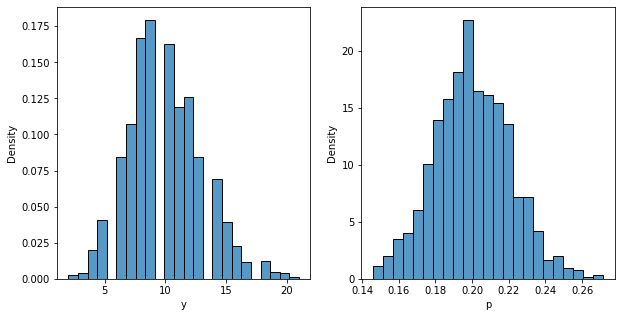

In [6]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
sns.histplot(data=sampl_df, x="y", stat="density", ax=axs[0])
sns.histplot(data=sampl_df, x="p", stat="density", ax=axs[1])
plt.plot()

In [7]:
sampl_df["p_v"] = 1 - (50 - sampl_df["y"])/50
sampl_df

,lp__,accept_stat__,y,p,p_v
0,0.0,0.0,9.0,0.178703,0.18
1,0.0,0.0,5.0,0.195038,0.10
2,0.0,0.0,9.0,0.160861,0.18
3,0.0,0.0,10.0,0.210781,0.20
4,0.0,0.0,15.0,0.204353,0.30
...,...,...,...,...,...
995,0.0,0.0,12.0,0.215697,0.24
996,0.0,0.0,18.0,0.215788,0.36
997,0.0,0.0,6.0,0.206471,0.12
998,0.0,0.0,9.0,0.182046,0.18


0.200041657
0.19952000000000003
0.0005216569999999809


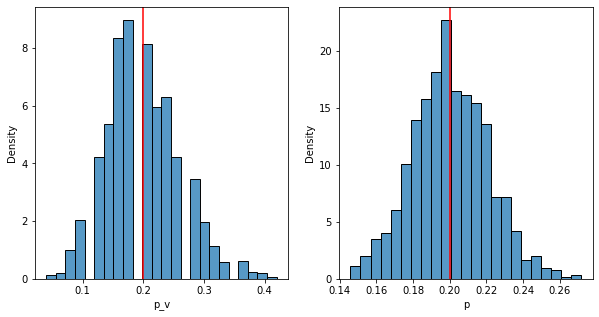

In [8]:
mean_p = sampl_df["p"].mean()
mean_p_v = sampl_df["p_v"].mean()

fig, axs = plt.subplots(1,2, figsize=(10,5))
sns.histplot(data=sampl_df, x="p_v", stat="density", ax=axs[0])
axs[0].axvline(mean_p_v, ymin=0, ymax=10, color="r")

sns.histplot(data=sampl_df, x="p", stat="density", ax=axs[1])
axs[1].axvline(mean_p, ymin=0, ymax=10, color="r")
plt.plot()
print(mean_p)
print(mean_p_v)
print(abs(mean_p_v-mean_p))

mean of the ratio is close to the mean of the actual results. Is is consistent with prior knowledge

# Modeling prior predictive distribution

1. Create a Stan model in which:
        ```N``` and ```y``` are appropriately defined in the data block.
        ```p``` is defined in the parameters block.
        binomial likelihood and prior (selected using prior predictive distribution) are defined in the model block.
        new integer variable ```y_pred``` in the generated quantities block.
        sample ```y_pred``` using values of parameter p and input variable N
2. Generate default number of samples from appropriate method in ```cmdstanpy```.
3. Compute ratio of predicted allergic reactions for each sample and create a histogram.
4. Compute the expected value and 94% density interval of the predicted ratio, compare it with expected value and 94% density interval of parameter ```p```. Use ```arviz``` package.
5. Compute the probability that ratio is lower than the average probability from traditional vaccines (count the number of simulated ratios that are smaller).


In [9]:
import arviz as az

In [10]:
stanmodel2 = CmdStanModel(stan_file='model2.stan')
sampl2 = stanmodel2.sample(data={"N":50, 'y': 7},
                           fixed_param=True,iter_sampling=1000,
                           iter_warmup=0,
                           chains=1)


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


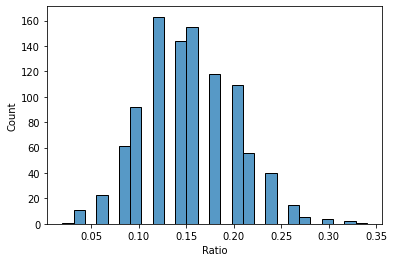

0.15288000000000002


In [31]:
sampl2_df = sampl2.draws_pd()
sampl2_df["Ratio"] = sampl2_df["y_pred"]/50
mean_p = sampl2_df["p"].mean()
mean_ratio = sampl2_df["Ratio"].mean()
sns.histplot(data=sampl2_df, x="Ratio")
# axs[0].axvline(mean_ratio,ymin=0, ymax=100, color="r")
plt.show()
print(mean_ratio)


In [12]:
ratio_pred = az.summary(np.array(sampl2_df["Ratio"]), hdi_prob=0.94)
print(ratio_pred)

p_density = az.summary(np.array(sampl2_df["p"]), hdi_prob=0.94)
print(p_density)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


    mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
x  0.153  0.05    0.06     0.24      0.002    0.001     955.0     855.0    NaN
    mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
x  0.151  0.0   0.151    0.151        0.0      0.0    1000.0    1000.0    NaN


In [24]:

p = sampl2_df["p"].to_numpy()
ratio = sampl2_df["Ratio"].to_numpy()
print(f"Percentage of lower ratios than the average for vaccines:  {np.mean(ratio < 0.2) * 100.0} %")



Percentage of lower ratios than the average for vaccines:  76.8 %
